<a href="https://colab.research.google.com/github/Angel-dash/Abstractive-Text-Summarization/blob/main/DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Uncomment the code below if you are running on google colab
If you are running the code on the google colab then you must have the data set on your google drive. Link to the dataset where you can download it form https://drive.google.com/file/d/1CAK0Cj1kNgoZ0FRxwwCflbh-1-hKDPoK/view?usp=sharing



In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)


Mounted at /content/drive


In [2]:
#!unzip /content/drive/MyDrive/DL/data.zip # Comment out for niranjan's
!unzip /content/drive/MyDrive/MiniProjectdata/amazon.zip #comment out for Angel's



Archive:  /content/drive/MyDrive/MiniProjectdata/amazon.zip
  inflating: Reviews.csv             
  inflating: database.sqlite         
  inflating: hashes.txt              


In [3]:
import numpy as np
import pandas as pd
import re
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")
import textwrap
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
#data_train=pd.read_csv('/content/cnn_dailymail/train.csv')
#data_test=pd.read_csv('/content/cnn_dailymail/test.csv')
#data_validation=pd.read_csv('/content/cnn_dailymail/validation.csv')
data=pd.read_csv('/content/Reviews.csv',nrows=50000)

Data preprocessing

In [5]:
#data = pd.concat([data_train, data_test, data_validation ])
df = data

In [6]:
new_df=df.sample(50000)

In [7]:
new_df.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
9634,9635,B001COE2RU,AZL1VUHSR6LS9,Ryn,3,3,5,1235520000,delicious!!,This is one of the best mixed nut blends I have ever had!<br />Everything tastes extremely fresh and natural. The flavor combination is amazing - perfect mix of nuts and dried fruits. I really lik...
1702,1703,B001RVFDOO,A30G6Q3WKQ2ONS,MeMoi27,165,168,5,1255737600,Yum!,"I was on the fence about buying these for months. I read the reviews and were impressed by them but, the possibility of being stuck with 24 bags of chips I hated made me nervous. This was my first..."
902,903,B000ER6YO0,A6LAMY7Z10BBJ,Amazon Shopper,4,4,4,1286928000,"Good flavor, too runny though","Baby loved this one, but as he has progressed I had to cut this one out because it is too runny and if I have to move the spoon quickly out of the way of his grabby hands, it is all over! I think ..."


In [8]:
new_df.shape

(50000, 10)

Checking for Null values


In [9]:
new_df.isna().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               3
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   2
Text                      0
dtype: int64

Checking for duplicates


In [10]:
new_df.duplicated(subset=['Text']).sum()

3746

In [11]:

new_df=new_df.drop_duplicates(subset=['Text'])
new_df.shape

(46254, 10)

In [12]:

new_df.duplicated(subset=['Text']).sum()


0

new_df['Text'][:10]

In [ ]:
# new_df['Text'] = new_df['Text'].str.lower()
# new_df['Summary'] = new_df['Summary'].str.lower()

# new_df.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
27400,27401,B0029NN4SG,ANDAE9GV2STPW,"Yogi Tarzan ""Big DVD user""",2,2,4,1256256000,good product,"i ordered this for my 10 year old dog who is having trouble with his leg - he has arthritis. after eating this dog food he seems to move better and has jumped on the couch a few times, which he c..."
8251,8252,B000E15DFM,A2MXK86XUUYR38,A. I. Albulooki,0,0,5,1336262400,delicious and salty,it's very delicious and i love salty foods .. but i wish that contains olive oil instead of safflower oil :(
15356,15357,B004AFODLI,A1TWM78I835NGZ,"Bryan K. Bailey ""Bryan Bailey""",0,0,5,1324857600,the only whole grain pancake mix i'll ever buy.,"i'll keep it brief. first, i usually don't like whole grain, multi-grain, or whole wheat pancake mixes. i bought this mix to put in a breakfast gift basket i was putting together and since i had..."


Converting to lower case

In [ ]:
# #removing html tags
# import re
# def remove_html_tags(text):
#     if isinstance(text, str):
#         pattern = re.compile('<.*?>')
#         return pattern.sub(r'', text)
#     else:
#         return text

In [ ]:
# new_df['Text'] = new_df['Text'].apply(remove_html_tags)

# new_df['Summary'] = new_df['Summary'].apply(remove_html_tags)

In [13]:
new_df.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
9634,9635,B001COE2RU,AZL1VUHSR6LS9,Ryn,3,3,5,1235520000,delicious!!,This is one of the best mixed nut blends I have ever had!<br />Everything tastes extremely fresh and natural. The flavor combination is amazing - perfect mix of nuts and dried fruits. I really lik...
1702,1703,B001RVFDOO,A30G6Q3WKQ2ONS,MeMoi27,165,168,5,1255737600,Yum!,"I was on the fence about buying these for months. I read the reviews and were impressed by them but, the possibility of being stuck with 24 bags of chips I hated made me nervous. This was my first..."
902,903,B000ER6YO0,A6LAMY7Z10BBJ,Amazon Shopper,4,4,4,1286928000,"Good flavor, too runny though","Baby loved this one, but as he has progressed I had to cut this one out because it is too runny and if I have to move the spoon quickly out of the way of his grabby hands, it is all over! I think ..."


In [ ]:
# #removing punchuation


# import string
# string.punctuation
# exclude = string.punctuation
# def remove_punc(text):
#     if isinstance(text, str):
#         return ''.join(ch for ch in text if ch not in exclude)
#     else:
#         return str(text)  # Convert non-string data to string

In [ ]:
# new_df['Text'] = new_df['Text'].apply(remove_punc)

# new_df['Summary'] = new_df['Summary'].apply(remove_punc)

In [ ]:
# from nltk.corpus import stopwords
# nltk.download('stopwords')
# stopwords = nltk.corpus.stopwords.words('english')

# print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# import nltk
# nltk.download('stopwords')
# from nltk.corpus import stopwords

# stop_words = stopwords.words('english')
# new_df['Text'] = new_df['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
# new_df['Summary'] = new_df['Summary'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# new_df.head(1)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
27400,27401,B0029NN4SG,ANDAE9GV2STPW,"Yogi Tarzan ""Big DVD user""",2,2,4,1256256000,good product,ordered 10 year old dog trouble leg arthritis eating dog food seems move better jumped couch times could awhile good experience amazon usual delivery highly recommend


In [14]:
#!pip install contractions
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [15]:
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:
            long_words.append(i)
    return (" ".join(long_words)).strip()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
#call the function
cleaned_text = []
for t in df['Text']:
    cleaned_text.append(text_cleaner(t,0))

In [17]:
cleaned_text[:5]

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']

In [18]:
df['Summary'] = df['Summary'].astype(str)

In [19]:
#call the function
cleaned_summary = []
for t in df['Summary']:
    cleaned_summary.append(text_cleaner(t,1))

In [20]:
cleaned_summary[:10]

['good quality dog food',
 'not as advertised',
 'delight says it all',
 'cough medicine',
 'great taffy',
 'nice taffy',
 'great just as good as the expensive brands',
 'wonderful tasty taffy',
 'yay barley',
 'healthy dog food']

In [21]:
df['cleaned_text']=cleaned_text
df['cleaned_summary']=cleaned_summary

In [22]:
df.replace('', np.nan, inplace=True)
df.dropna(axis=0,inplace=True)

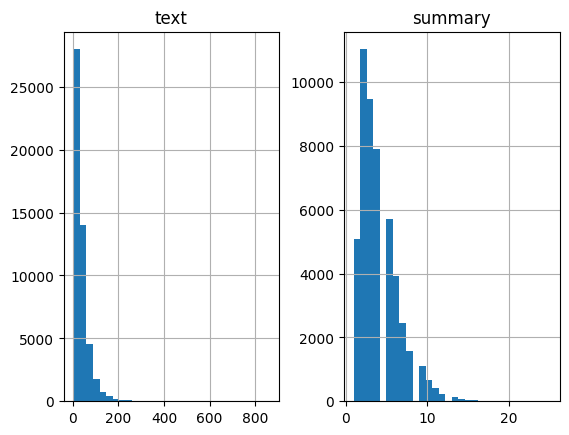

In [23]:

import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in df['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in df['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [24]:
max_len_text=150
max_len_summary=10

In [25]:
cnt=0
for i in df['cleaned_summary']:
    if(len(i.split())<=8):
        cnt=cnt+1
print(cnt/len(df['cleaned_summary']))

0.9439695726153539


In [26]:
cleaned_text =np.array(df['cleaned_text'])
cleaned_summary=np.array(df['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_len_summary and len(cleaned_text[i].split())<=max_len_text):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])

df=pd.DataFrame({'text':short_text,'summary':short_summary})

In [27]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [28]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.1,random_state=0,shuffle=True)

In [29]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

In [30]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 62.19012527634488
Total Coverage of rare words: 2.020339400939721


In [31]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt)
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr)
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_len_text, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_len_text, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1


In [32]:
x_voc

12828

In [33]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

In [34]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 76.02314571278275
Total Coverage of rare words: 5.032184899452138


In [35]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt)
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr)
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val)

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_len_summary, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_len_summary, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

In [36]:
y_voc

2280

In [37]:
y_tokenizer.word_counts['sostok'],len(y_tr)

(43380, 43380)

In [38]:
type(y_tr)

numpy.ndarray

In [39]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [40]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

LSTM model building

In [41]:
from keras import backend as K
K.clear_session()
latent_dim = 350
#embedding_dim=200 #Keeping latent dimension to 300 and introducing embedding dimension of 100 to reduce the number of parameters of the model
#condider chaging the latent_dim to smaller value such as 100 or 300
#also adding a seperate embedding_dim can help to reduce the compleixity of the model

In [42]:
#encoder
encoder_inputs = Input(shape=(max_len_text,))
enc_emb = Embedding(x_voc, latent_dim,trainable=True)(encoder_inputs)

In [43]:
#LSTM 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#LSTM2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)


In [44]:
#decoder
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(y_voc, latent_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

In [45]:

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])



In [46]:
#pip install attention_keras
import tensorflow as tf
from tensorflow.python.keras import backend as K

logger = tf.get_logger()

class AttentionLayer(tf.keras.layers.Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs,verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs

        logger.debug(f"encoder_out_seq.shape = {encoder_out_seq.shape}")
        logger.debug(f"decoder_out_seq.shape = {decoder_out_seq.shape}")

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            logger.debug("Running energy computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_full_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim

            logger.debug(f"U_a_dot_h.shape = {U_a_dot_h.shape}")

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)

            logger.debug(f"Ws_plus_Uh.shape = {Ws_plus_Uh.shape}")

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            logger.debug(f"ei.shape = {e_i.shape}")

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            logger.debug("Running attention vector computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_full_seq * K.expand_dims(inputs, -1), axis=1)

            logger.debug(f"ci.shape = {c_i.shape}")

            return c_i, [c_i]

        # we don't maintain states between steps when computing attention
        # attention is stateless, so we're passing a fake state for RNN step function
        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e], constants=[encoder_out_seq]
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c], constants=[encoder_out_seq]
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [47]:
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

In [48]:
# Concat attention output and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])


In [49]:
#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

In [50]:
# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 150, 350)             4489800   ['input_1[0][0]']             
                                                                                                  
 lstm (LSTM)                 [(None, 150, 350),           981400    ['embedding[0][0]']           
                              (None, 350),                                                        
                              (None, 350)]                                                        
                                                                                              

In [51]:
model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy') #using Adam optimizer instead of rms for better performance and efficieny in terms of speed

In [52]:
#using Early stoppage to stop the training of the model once the validation increasers
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [53]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Specify the path to save the model
# You can change 'model.h5' to your preferred file name
model_path = '/content/drive/MyDrive/savedModels'

# Create a ModelCheckpoint callback
#checkpoint = ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=False, save_freq=3)
checkpoint = ModelCheckpoint(filepath=model_path + "/model_epoch{epoch}.h5", monitor='val_loss', verbose=1, save_best_only=False, save_freq='epoch', period=3)
# Add the callback to your model's fit method
history=model.fit(
    [x_tr,y_tr[:,:-1]],
    y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,
    epochs=20,callbacks=[checkpoint,es],
    batch_size=256, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))


Epoch 1/20
167/167 [==============================] - 384s 2s/step - loss: 2.7888 - val_loss: 2.4478
Epoch 2/20
167/167 [==============================] - 338s 2s/step - loss: 2.4115 - val_loss: 2.3235
Epoch 3/20
167/167 [==============================] - ETA: 0s - loss: 2.2734
Epoch 3: saving model to /content/drive/MyDrive/savedModels/model_epoch3.h5
167/167 [==============================] - 339s 2s/step - loss: 2.2734 - val_loss: 2.2084
Epoch 4/20
167/167 [==============================] - 328s 2s/step - loss: 2.1726 - val_loss: 2.1416
Epoch 5/20
167/167 [==============================] - 325s 2s/step - loss: 2.0923 - val_loss: 2.0703
Epoch 6/20
167/167 [==============================] - ETA: 0s - loss: 2.0051
Epoch 6: saving model to /content/drive/MyDrive/savedModels/model_epoch6.h5
167/167 [==============================] - 331s 2s/step - loss: 2.0051 - val_loss: 2.0005
Epoch 7/20
167/167 [==============================] - 327s 2s/step - loss: 1.9194 - val_loss: 1.9538
Epoch 8/2

In [54]:
model.save('model.h5')


from nltk.translate.bleu_score import corpus_bleu

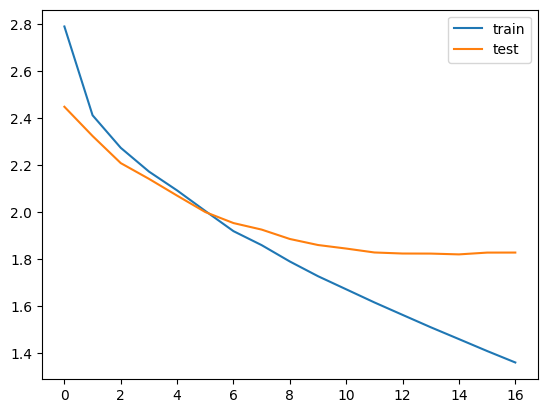

In [55]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [56]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [57]:
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])


In [58]:
# decoder inference
# Below tensors will hold the states of the previous time step

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))



In [59]:
# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

In [60]:
 # To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])




In [61]:
#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

In [62]:
# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

In [63]:
# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [64]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_len_summary-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [72]:
def seq2summary(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0 and i != target_word_index['sostok'] and i != target_word_index['eostok']:
            newString = newString + reverse_target_word_index[i] + ' '
    return newString.strip() # Use strip() to remove trailing spaces


def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+reverse_source_word_index[i]+' '
    return newString

In [73]:
for i in range(0,100):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_len_text)))
    print("\n")

Review: water great prefer normal flavor passion fruit version good stuff great workout bike ride also great prevent hangover seems replenish necessary minerals etc give pleasant recovery packaging great boxes simple open stay cold long time drawback price 
Original summary: excellent coconut water great packaging
1/1 [==============================] - 0s 21ms/step
Predicted summary:  great taste


Review: received item quickly greatly impressed sellers shipping speed first cup tried tea water great way second non dairy milk honey much better bitterness actual matcha taste faint would recommend adding non dairy milk honey enhance flavor would say like tea tried better great quantity best quality 
Original summary: matcha
1/1 [==============================] - 0s 20ms/step
Predicted summary:  great product


Review: price equal quality best 
Original summary: terrific find
1/1 [==============================] - 0s 23ms/step
Predicted summary:  great deal


Review: one reviews yogourmet 

In [74]:
#after removing the sos and eos token
from nltk.translate.bleu_score import sentence_bleu

total_bleu_score = 0
review_count = 0

for i in range(0, 100):
    reference = [seq2text(x_tr[i]).split()] # Convert original summary to list of words
    candidate = decode_sequence(x_tr[i].reshape(1, max_len_text)).split() # Convert predicted summary to list of words

    # Calculate BLEU score
    score = sentence_bleu(reference, candidate)
    total_bleu_score += score
    review_count += 1

# Calculate average BLEU score
average_bleu_score = total_bleu_score / review_count
print(f"Average BLEU score: {average_bleu_score}")

1/1 [==============================] - 0s 21ms/step
Average BLEU score: 1.1137167090798977e-82


In [75]:
# Assuming x_tr and y_tr are your original and predicted summaries
for i in range(0, 100):
    reference = [seq2text(x_tr[i]).split()] # Convert original summary to list of words
    candidate = decode_sequence(x_tr[i].reshape(1, max_len_text)).split() # Convert predicted summary to list of words

    # Calculate BLEU score
    score = sentence_bleu(reference, candidate)
    print(f"Review {i}: BLEU score = {score}")

1/1 [==============================] - 0s 19ms/step
Review 0: BLEU score = 3.846780371301839e-239
1/1 [==============================] - 0s 24ms/step
Review 1: BLEU score = 4.273386982817057e-241
1/1 [==============================] - 0s 65ms/step
Review 2: BLEU score = 0
1/1 [==============================] - 0s 36ms/step
Review 3: BLEU score = 2.2079078370057786e-246
1/1 [==============================] - 0s 34ms/step
Review 4: BLEU score = 3.947519713989297e-249
1/1 [==============================] - 0s 124ms/step
Review 5: BLEU score = 3.1170784199608393e-235
1/1 [==============================] - 0s 21ms/step
Review 6: BLEU score = 4.686337864153731e-238
1/1 [==============================] - 0s 74ms/step
Review 7: BLEU score = 5.273778503360198e-245
1/1 [==============================] - 0s 42ms/step
Review 8: BLEU score = 1.0456633181382725e-238
1/1 [==============================] - 0s 64ms/step
Review 9: BLEU score = 0
1/1 [==============================] - 0s 115ms/step
Revie

In [76]:
!pip install transformers bert-score
from transformers import BertTokenizer, BertModel
from bert_score import BERTScorer

# Initialize BERTScorer
scorer = BERTScorer(model_type='bert-base-uncased')

# Assuming x_tr and y_tr are your original and predicted summaries
for i in range(0, 100):
    print("Review:", seq2text(x_tr[i]))

    # Original summary
    original_summary = seq2summary(y_tr[i])
    print("Original summary:", original_summary)

    # Predicted summary
    predicted_summary = decode_sequence(x_tr[i].reshape(1, max_len_text))
    print("Predicted summary:", predicted_summary)

    # Calculate BERTScore
    P, R, F1 = scorer.score([predicted_summary], [original_summary])
    print(f"BERTScore Precision: {P.mean():.4f}, Recall: {R.mean():.4f}, F1: {F1.mean():.4f}")

    print("\n")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 59.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 65.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 93.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 570.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Review: water great prefer normal flavor passion fruit version good stuff great workout bike ride also great prevent hangover seems replenish necessary minerals etc give pleasant recovery packaging great boxes simple open stay cold long time drawback price 
Original summary: excellent coconut water great packaging
1/1 [==============================] - 0s 35ms/step
Predicted summary:  great taste
BERTScore Precision: 0.5848, Recall: 0.4707, F1: 0.5216


Review: received item quickly greatly impressed sellers shipping speed first cup tried tea water great way second non dairy milk honey much better bitterness actual matcha taste faint would recommend adding non dairy milk honey enhance flavor would say like tea tried better great quantity best quality 
Original summary: matcha
1/1 [==============================] - 0s 20ms/step
Predicted summary:  great product
BERTScore Precision: 0.4282, Recall: 0.4221, F1: 0.4252


Review: price equal quality best 
Original summary: terrific find
1/1

In [77]:
from transformers import BertTokenizer, BertModel
from bert_score import BERTScorer

# Initialize BERTScorer
scorer = BERTScorer(model_type='bert-base-uncased')

total_precision = 0
total_recall = 0
total_f1 = 0
review_count = 0

for i in range(0, 100):
    print("Review:", seq2text(x_tr[i]))

    # Original summary
    original_summary = seq2summary(y_tr[i])
    print("Original summary:", original_summary)

    # Predicted summary
    predicted_summary = decode_sequence(x_tr[i].reshape(1, max_len_text))
    print("Predicted summary:", predicted_summary)

    # Calculate BERTScore
    P, R, F1 = scorer.score([predicted_summary], [original_summary])
    print(f"BERTScore Precision: {P.mean():.4f}, Recall: {R.mean():.4f}, F1: {F1.mean():.4f}")

    # Accumulate scores
    total_precision += P.mean()
    total_recall += R.mean()
    total_f1 += F1.mean()
    review_count += 1

    print("\n")

# Calculate average BERTScore
average_precision = total_precision / review_count
average_recall = total_recall / review_count
average_f1 = total_f1 / review_count

print(f"Average BERTScore Precision: {average_precision:.4f}")
print(f"Average BERTScore Recall: {average_recall:.4f}")
print(f"Average BERTScore F1: {average_f1:.4f}")


Review: water great prefer normal flavor passion fruit version good stuff great workout bike ride also great prevent hangover seems replenish necessary minerals etc give pleasant recovery packaging great boxes simple open stay cold long time drawback price 
Original summary: excellent coconut water great packaging
1/1 [==============================] - 0s 73ms/step
Predicted summary:  great taste
BERTScore Precision: 0.5848, Recall: 0.4707, F1: 0.5216


Review: received item quickly greatly impressed sellers shipping speed first cup tried tea water great way second non dairy milk honey much better bitterness actual matcha taste faint would recommend adding non dairy milk honey enhance flavor would say like tea tried better great quantity best quality 
Original summary: matcha
1/1 [==============================] - 0s 55ms/step
Predicted summary:  great product
BERTScore Precision: 0.4282, Recall: 0.4221, F1: 0.4252


Review: price equal quality best 
Original summary: terrific find
1/1

In [68]:
from nltk.translate.bleu_score import sentence_bleu

total_bleu_score = 0
review_count = 0

for i in range(0, 100):
    reference = [seq2text(x_tr[i]).split()] # Convert original summary to list of words
    candidate = decode_sequence(x_tr[i].reshape(1, max_len_text)).split() # Convert predicted summary to list of words

    # Calculate BLEU score
    score = sentence_bleu(reference, candidate)
    total_bleu_score += score
    review_count += 1

# Calculate average BLEU score
average_bleu_score = total_bleu_score / review_count
print(f"Average BLEU score: {average_bleu_score}")


1/1 [==============================] - 0s 20ms/step
Average BLEU score: 1.1137167090798977e-82


In [69]:
# Assuming x_tr and y_tr are your original and predicted summaries
for i in range(0, 100):
    reference = [seq2text(x_tr[i]).split()] # Convert original summary to list of words
    candidate = decode_sequence(x_tr[i].reshape(1, max_len_text)).split() # Convert predicted summary to list of words

    # Calculate BLEU score
    score = sentence_bleu(reference, candidate)
    print(f"Review {i}: BLEU score = {score}")

1/1 [==============================] - 0s 104ms/step
Review 0: BLEU score = 3.846780371301839e-239
1/1 [==============================] - 0s 38ms/step
Review 1: BLEU score = 4.273386982817057e-241
1/1 [==============================] - 0s 31ms/step
Review 2: BLEU score = 0
1/1 [==============================] - 0s 37ms/step
Review 3: BLEU score = 2.2079078370057786e-246
1/1 [==============================] - 0s 21ms/step
Review 4: BLEU score = 3.947519713989297e-249
1/1 [==============================] - 0s 20ms/step
Review 5: BLEU score = 3.1170784199608393e-235
1/1 [==============================] - 0s 23ms/step
Review 6: BLEU score = 4.686337864153731e-238
1/1 [==============================] - 0s 20ms/step
Review 7: BLEU score = 5.273778503360198e-245
1/1 [==============================] - 0s 21ms/step
Review 8: BLEU score = 1.0456633181382725e-238
1/1 [==============================] - 0s 21ms/step
Review 9: BLEU score = 0
1/1 [==============================] - 0s 21ms/step
Review